In [1]:
%matplotlib inline
import numpy as np
import skimage as ski
import skimage.io

In [74]:
A = ski.io.imread('data/test/lena.png')
B = ski.io.imread('data/test/barbara.png')

In [119]:
def imfix(X, **kwargs):
    assert 'overflow' in kwargs
    overflow = kwargs['overflow']
    
    # Assume gray scale...
    typed = np.uint8
    if 'dtype' in kwargs:
        typed = kwargs['dtype']
        
    if overflow == 'cap':
        assert 'cap_max' in kwargs
        return np.minimum(X, kwargs['cap_max']).astype(typed)
    elif overflow == 'mod':
        assert 'mod_max' in kwargs
        return np.mod(X, kwargs['mod_max']).astype(typed)
    
# Ejercicio 1a, suma de imágenes
def imsum(A, B, **kwargs):
    assert A.shape == B.shape
    return imfix(np.sum([A, B], axis=0, dtype=np.uint64), **kwargs)

# Ejercicio 1b, producto de una imágen por un escalar
def improd(alpha, A, **kwargs):
    return imfix(np.multiply(alpha, A, dtype=np.double), **kwargs)

# Ejercicio 1c
def dynrange(A, target, **kwargs):
    # Utilizamos 1 + R porque R puede ser 0, y el logarítmo no está definido en 0
    c = float(target) / np.log(1 + np.max(A))
    return (c * np.log(1 + A)).astype(np.uint8)

# Ejercicio 2
def imneg(A, max_value=255):
    return max_value - A

# Ejercicio 3
def imbinarize(A, threshold=128, max_value=255, min_value=0):
    X = np.copy(A)
    indexes = X > threshold
    X[indexes] = max_value
    X[np.invert(indexes)] = min_value
    return X

# Ejercicio 4:
def imbits(A):
    pass

# Ejercicio 5
def imhist(A):
    pass

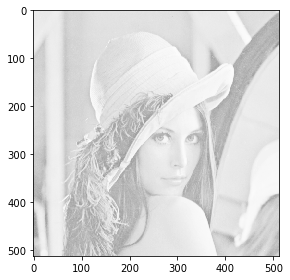

In [120]:
ski.io.imshow(dynrange(A, 255))

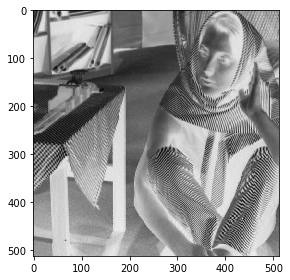

In [90]:
ski.io.imshow(imneg(B))

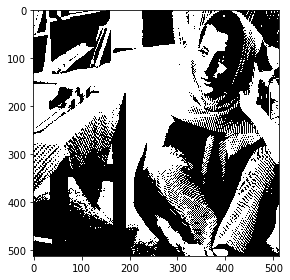

In [85]:
ski.io.imshow(imbinarize(B, 120))

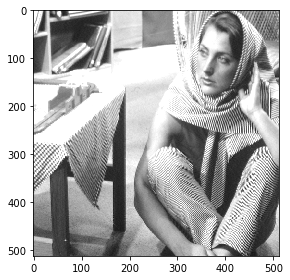

In [49]:
ski.io.imshow(improd(1.42, B, overflow='cap', cap_max=255))

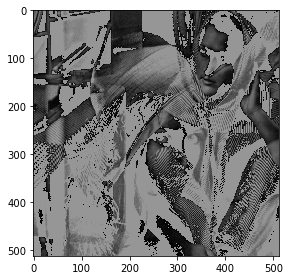

In [5]:
ski.io.imshow(imsum(A, B, overflow='cap', cap_max=150))

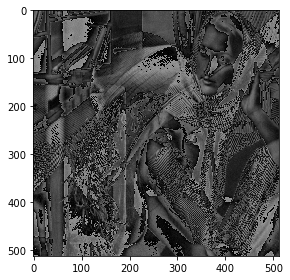

In [6]:
ski.io.imshow(imsum(A, B, overflow='mod', mod_max=150))